In [11]:
! pip install yfinance

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import warnings
from tensorflow.keras.utils import get_file
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN

In [14]:
def data_to_X_y(temp, window_size=5):
  data_as_np=temp.to_numpy()
  X = []
  y = []
  for i in range(len(data_as_np)-window_size):
    row = [[a] for a in data_as_np[i:i+5]]
    X.append(row)
    label = data_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [15]:
def train_test_val_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  print('Train Set: ', X_train.shape, y_train.shape)
  print('Test Set: ', X_test.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [16]:
# Performance Metric
def metric(model, X_test, y_test):
  yhat=model.predict(X_test)
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]

In [17]:
score_dict={}

In [18]:
def jitter_series(series, noise_level=0.02):
    return series + noise_level * np.random.randn(len(series))

# **Climate Data**

In [19]:
# Download and load the dataset
zip_path = get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
data = pd.read_csv(csv_path)

In [20]:
data.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


<Axes: xlabel='Date Time'>

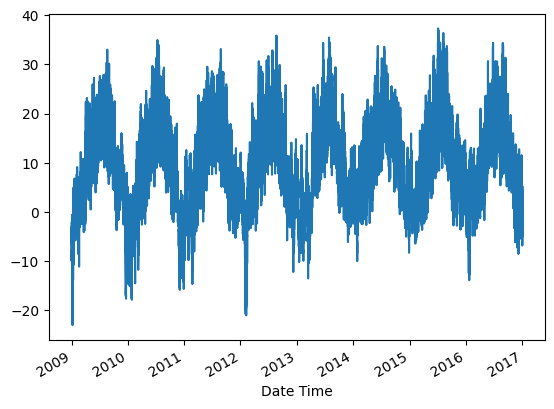

In [21]:
data.index = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
temp =data['T (degC)']
temp= jitter_series(temp)
temp.plot()

In [22]:
WINDOW_SIZE=5
X, y=data_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (294382, 5, 1) (294382,)
Test Set:  (126164, 5, 1) (126164,)


## **LSTM**

In [23]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(24))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 1.0230 - val_loss: 0.0473
Epoch 2/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0541 - val_loss: 0.0452
Epoch 3/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 0.0509 - val_loss: 0.0526
Epoch 4/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0494 - val_loss: 0.0533
Epoch 5/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0485 - val_loss: 0.0479
Epoch 6/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0480 - val_loss: 0.0451
Epoch 7/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0477 - val_loss: 0.0443
Epoch 8/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 0.0474 - val_loss: 0.0443
Epoch 9/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0472 - val_loss: 0.0442
Epoch 10/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.0470 - val_loss: 0.0440


In [24]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Climate']= LSTM_

3943/3943 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
RMSE 0.20966242422970374
MSE 0.04395833213387626
MAE 0.13561836084808396


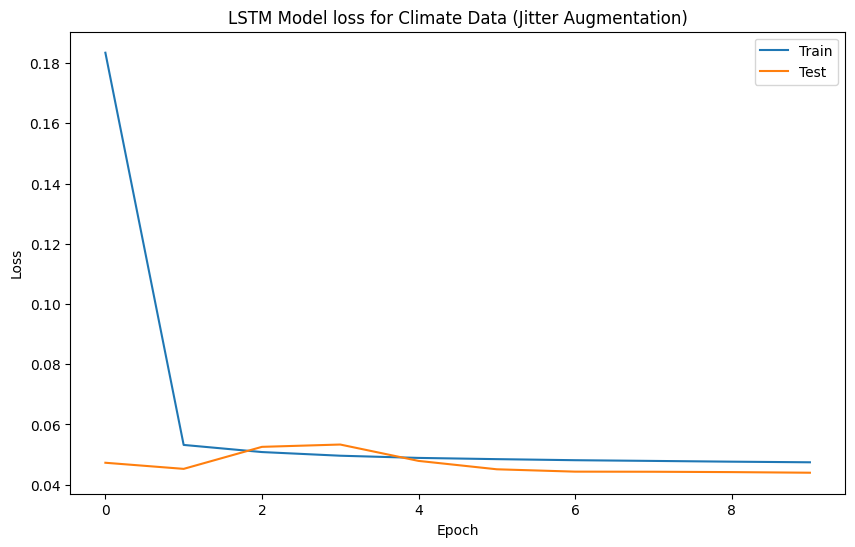

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for Climate Data (Jitter Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

9200/9200 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


Text(0.5, 1.0, 'LSTM Model Classification for Climate Data (Jitter Augmentation)')

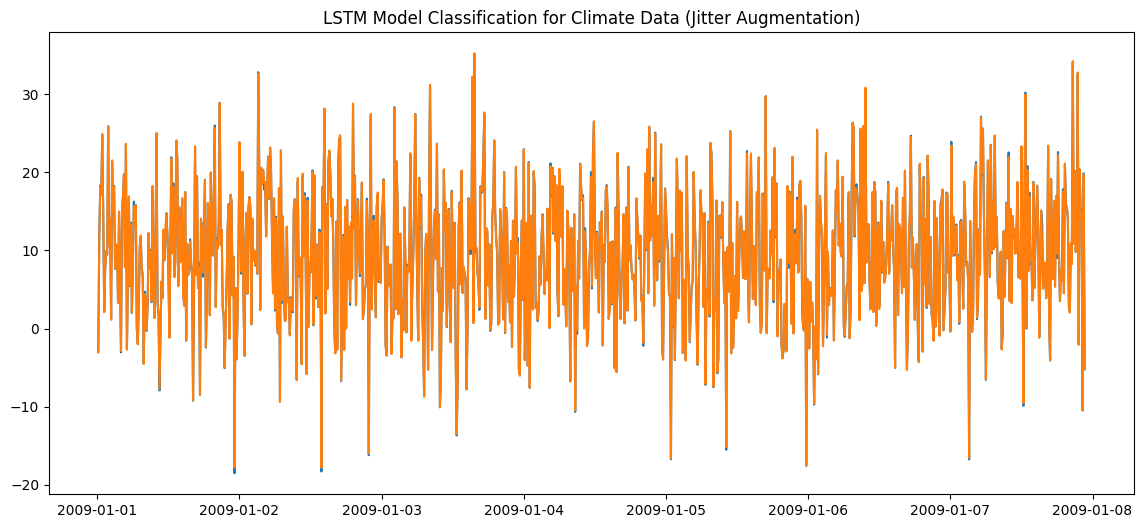

In [26]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=temp.head(294382).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])
plt.title('LSTM Model Classification for Climate Data (Jitter Augmentation)')

3943/3943 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


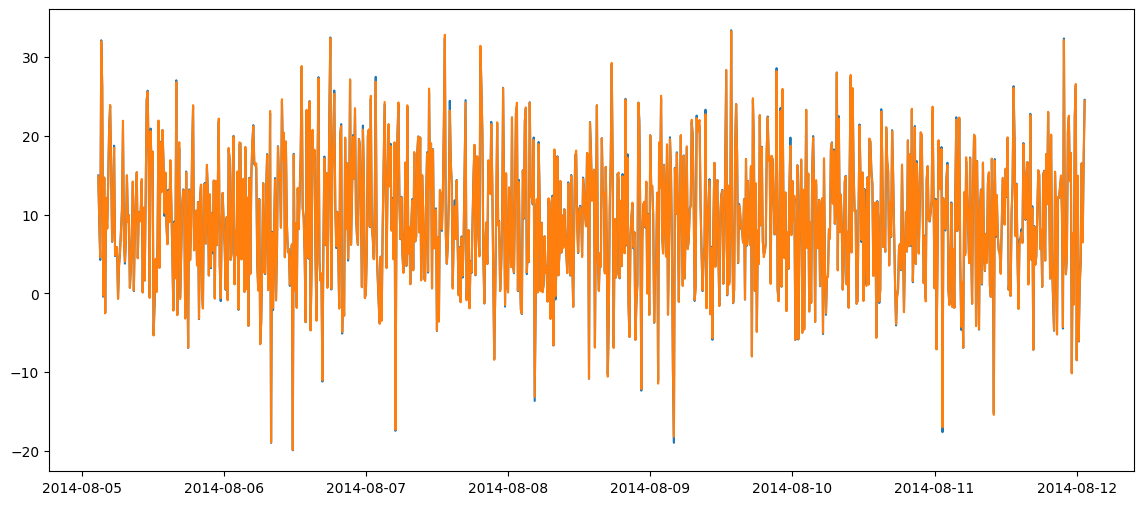

In [27]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=temp.tail(126164).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **ARIMA**

In [28]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(temp, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Climate']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

RMSE 11.495638979008305
MSE 132.14971553569512
MAE 9.218368285945537


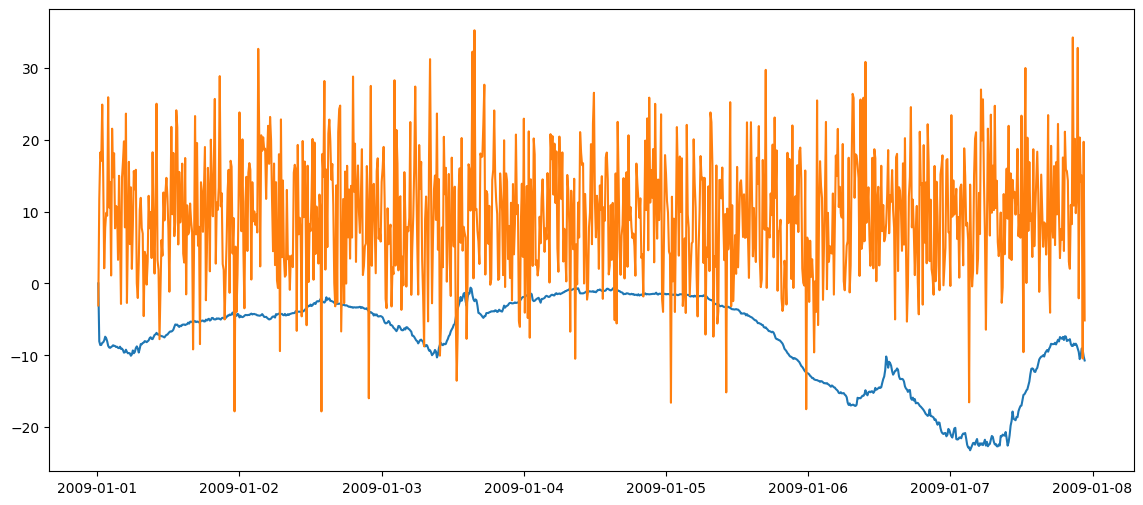

In [29]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

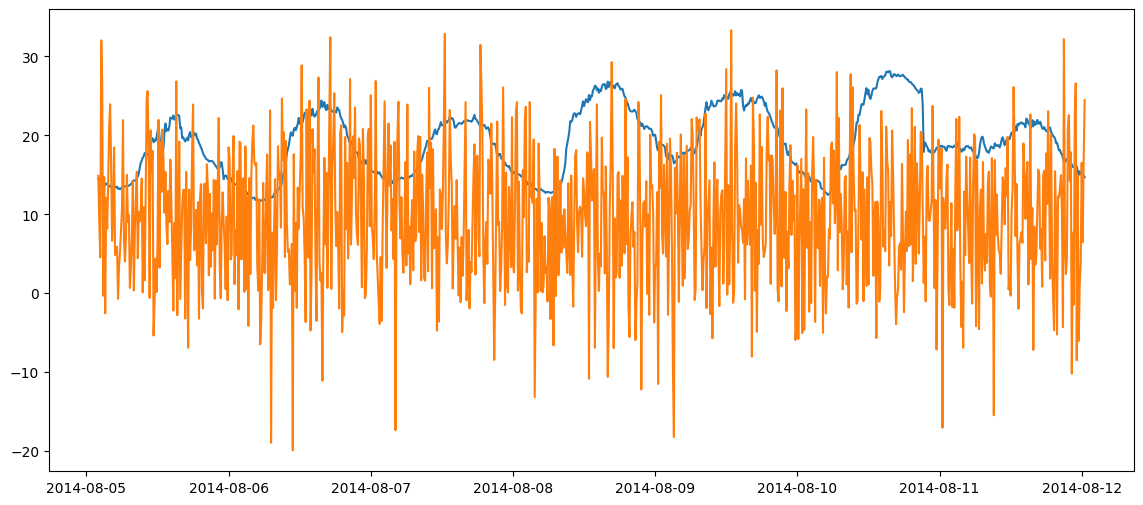

In [30]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [31]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'ARIMA': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'ARIMA': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Climate']= stacked_

RMSE 0.20931292667077672
MSE 0.04381190127148595
MAE 0.13525899029360633


In [66]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming LSTM and ARIMA predictions are already obtained and stored
# For training
df_train = pd.DataFrame({
    'LSTM': train_predictions_lstm,
    'ARIMA': train_predictions_arima
})
y_train = np.array(y_train)  # Ensure y_train is a numpy array

# For testing
df_test = pd.DataFrame({
    'LSTM': test_predictions_lstm,
    'ARIMA': test_predictions_arima
})
y_test = np.array(y_test)  # Ensure y_test is a numpy array

# Simple Averaging Ensemble (SAE)
def simple_averaging(df):
    return df.mean(axis=1)

# Weighted Averaging Ensemble (WAE)
def weighted_averaging(df, weights):
    return np.dot(df, weights)

# Calculate SAE predictions
sae_predictions = simple_averaging(df_test)

# Calculate WAE predictions
# Example weights based on performance metrics from metric() function
weights = [0.5, 0.5]  # Example weights, should be based on the model's performance

wae_predictions = weighted_averaging(df_test, weights)

# Metrics calculation function
def calculate_metrics(y_true, y_pred):
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    MSE = mean_squared_error(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    return [RMSE, MSE, MAE]

# Calculate metrics for SAE
sae_metrics = calculate_metrics(y_test, sae_predictions)
score_dict['SAE_Climate'] = sae_metrics

# Calculate metrics for WAE
wae_metrics = calculate_metrics(y_test, wae_predictions)
score_dict['WAE_Climate'] = wae_metrics

# Print out metrics
print(f'SAE Metrics: RMSE = {sae_metrics[0]}, MSE = {sae_metrics[1]}, MAE = {sae_metrics[2]}')
print(f'WAE Metrics: RMSE = {wae_metrics[0]}, MSE = {wae_metrics[1]}, MAE = {wae_metrics[2]}')


SAE Metrics: RMSE = 0.020781174793754232, MSE = 0.0004318572258085662, MAE = 0.016656765924311243
WAE Metrics: RMSE = 0.020781174793754232, MSE = 0.0004318572258085662, MAE = 0.016656765924311243


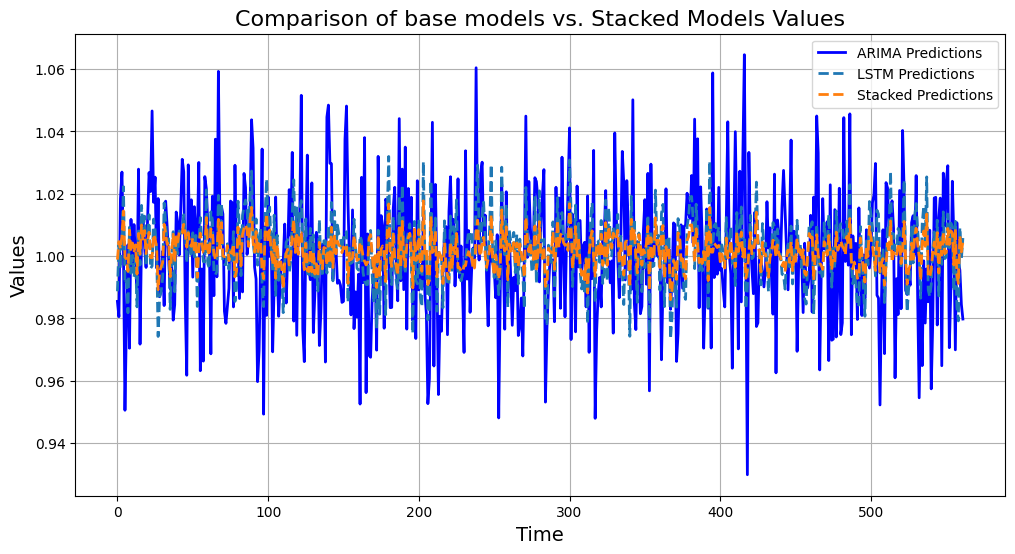

In [78]:
import matplotlib.pyplot as plt

# Define a function to plot actual vs. predicted values
def plot_comparison(y_test, predictions_dict, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="ARIMA Predictions", color="blue", linewidth=2)

    # Plot predictions for each model
    for label, preds in predictions_dict.items():
        plt.plot(preds, label=label, linestyle='--', linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare the predictions dictionary for plotting
predictions_dict = {
    'LSTM Predictions': test_predictions_lstm,
    #'ARIMA Predictions': test_predictions_arima,
    #'SAE Predictions': sae_predictions,
    'Stacked Predictions': wae_predictions
}

# Plot the comparison
plot_comparison(y_test, predictions_dict, 'Comparison of base models vs. Stacked Models Values')

# Optionally, you might want to include a plot for each model separately
def plot_individual_comparisons(y_test, model_predictions, model_name):
    plt.figure(figsize=(14, 8))
    plt.plot(y_test, label="Actual Values", color="blue", linewidth=2)
    plt.plot(model_predictions, label=f'{model_name} Predictions', linestyle='--', linewidth=2)
    plt.title(f'Actual vs {model_name} Predictions', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

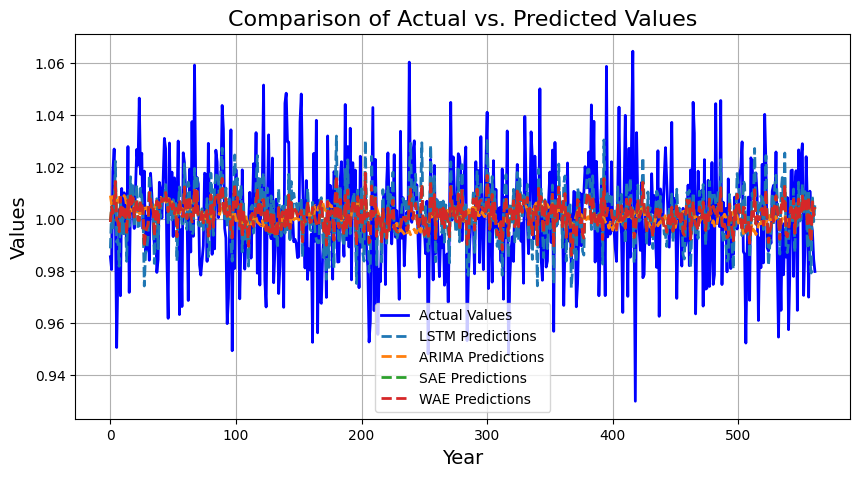

In [89]:
import matplotlib.pyplot as plt

# Define a function to plot actual vs. predicted values with x-axis as years
def plot_comparison(y_test, predictions_dict, years, title):
    plt.figure(figsize=(10, 5))
    plt.plot(years, y_test, label="Actual Values", color="blue", linewidth=2)

    # Plot predictions for each model
    for label, preds in predictions_dict.items():
        plt.plot(years, preds, label=label, linestyle='--', linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare the predictions dictionary for plotting
predictions_dict = {
    'LSTM Predictions': test_predictions_lstm,
    'ARIMA Predictions': test_predictions_arima,
    'SAE Predictions': sae_predictions,
    'WAE Predictions': wae_predictions
}

# Assuming `years` is a list or array with the corresponding year values for the x-axis
years = np.arange(len(y_test))  # Replace this with actual year values if available

# Plot the comparison
plot_comparison(y_test, predictions_dict, years, 'Comparison of Actual vs. Predicted Values')




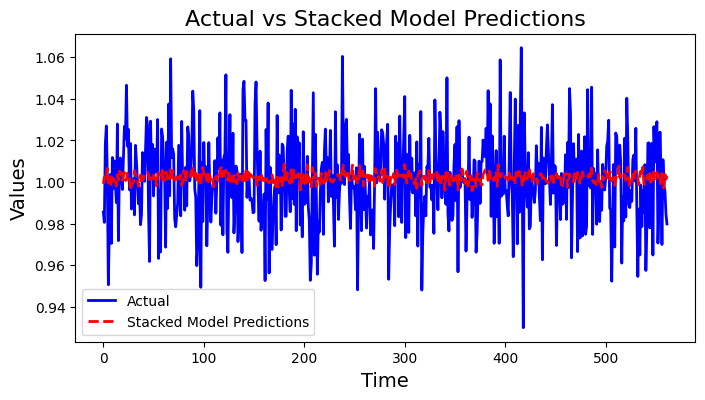

In [65]:
import matplotlib.pyplot as plt

# Generate predictions using the stacked model
stacked_predictions = Lr.predict(df_test)

# Plotting the actual vs. predicted values
plt.figure(figsize=(8, 4))

# Plot actual values
plt.plot(y_test, label="Actual", color="blue", linewidth=2)

# Plot stacked model predictions
plt.plot(stacked_predictions, label="Stacked Model Predictions", color="red", linestyle='--', linewidth=2)

# Adding title and labels
plt.title('Actual vs Stacked Model Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Show legend
plt.legend()

# Display the plot
plt.show()


# **Crypto Dataset (USDT)**

In [32]:
# Get bitcoin data
data=  yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2022-12-31').reset_index()
data.head(2)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-09 00:00:00+00:00,1.01087,1.01327,0.996515,1.00818,358188000,0.0,0.0
1,2017-11-10 00:00:00+00:00,1.00650,1.02423,0.995486,1.00601,756446016,0.0,0.0


<Axes: xlabel='Date'>

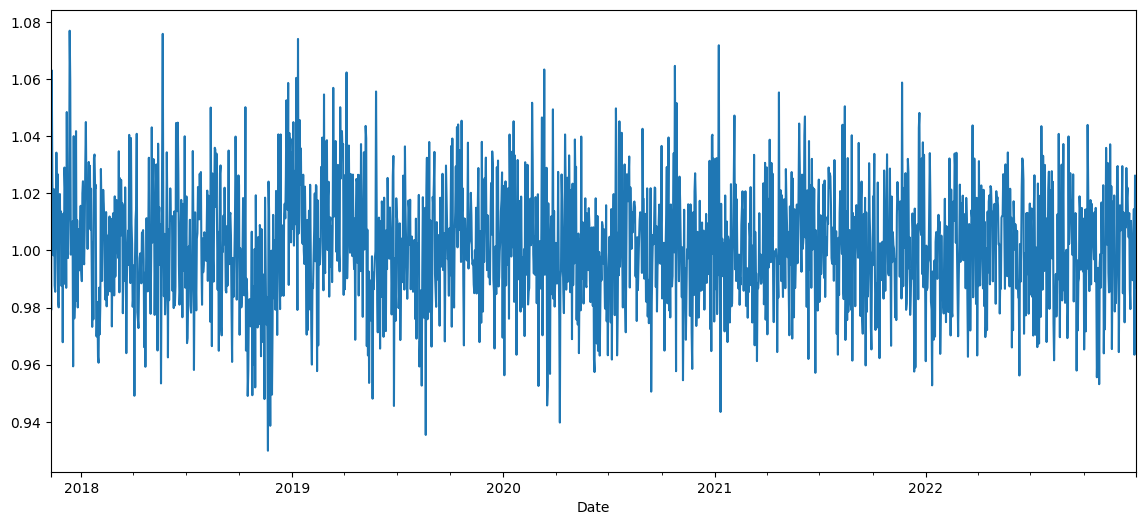

In [33]:
data.index = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S')
plt.figure(figsize=(14, 6))
usdt=data['Close']
usdt = jitter_series(usdt)
usdt.plot()

In [34]:
X, y=data_to_X_y(usdt, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (1311, 5, 1) (1311,)
Test Set:  (562, 5, 1) (562,)


## **LSTM**

In [35]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.8560 - val_loss: 0.4566
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3014 - val_loss: 0.0071
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 4.6618e-04
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1013e-04 - val_loss: 4.6644e-04
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8840e-04 - val_loss: 4.6760e-04
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8834e-04 - val_loss: 4.6763e-04
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8841e-04 - val_loss: 4.6754e-04
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8845e-04 - val_loss: 4.6753e-04
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8846e-04 - val_loss: 4.6760e-04
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8847e-04 - val_loss: 4.6771e-04


In [36]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_USDT']= LSTM_

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
RMSE 0.02162668775716547
MSE 0.0004677136233459309
MAE 0.017503602695225214


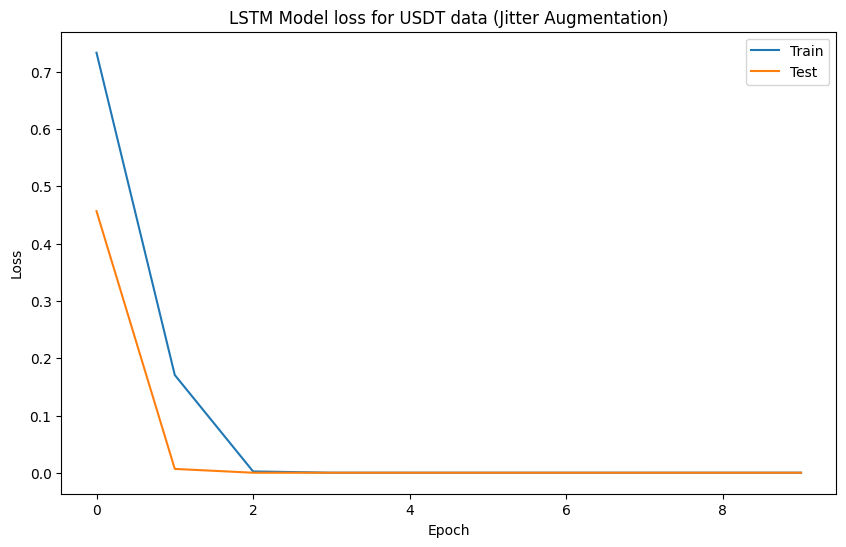

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for USDT data (Jitter Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Text(0.5, 1.0, 'LSTM Model Classification for USDT data (Jitter Augmentation)')

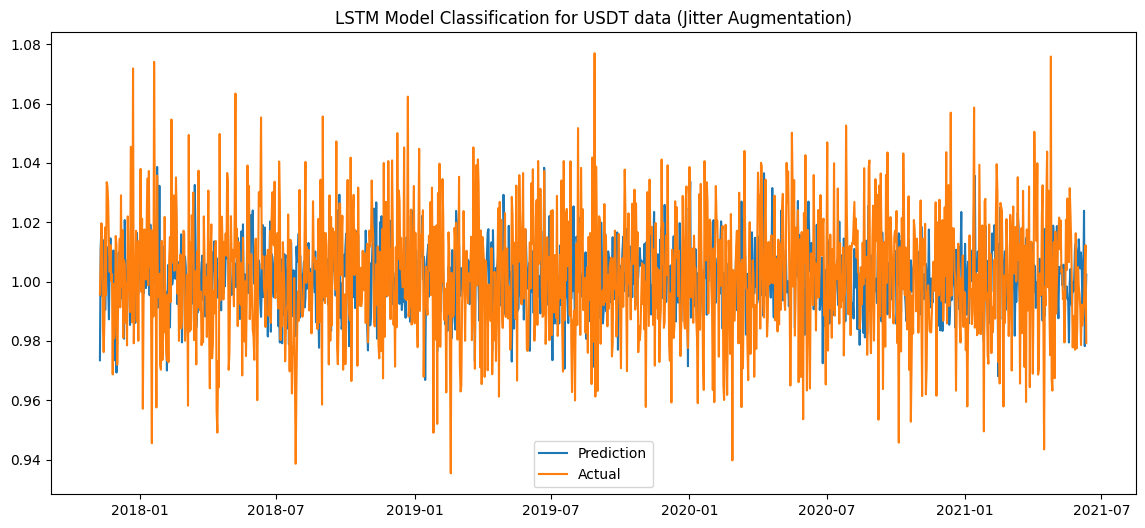

In [38]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=usdt.head(1311).index
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'], label='Prediction')
plt.plot(train_results['Actuals'], label='Actual')
plt.legend()
plt.title('LSTM Model Classification for USDT data (Jitter Augmentation)')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


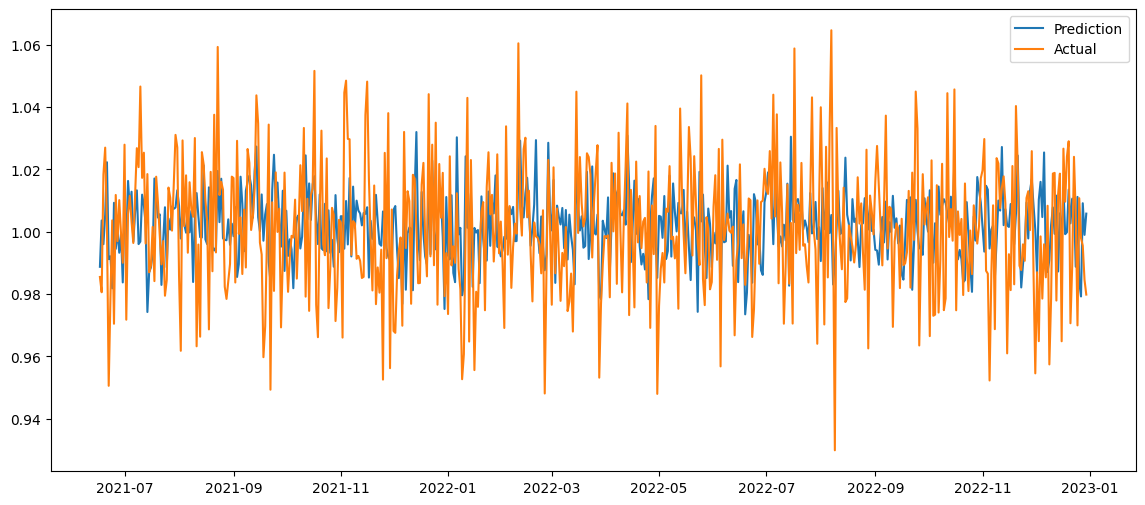

In [39]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=usdt.tail(562).index
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.plot(test_results['Actuals'], label='Actual')
plt.legend()

## **ARIMA**

In [40]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(usdt, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_usdt']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE 0.021436909786572513
MSE 0.00045954110119764835
MAE 0.01703473364265528


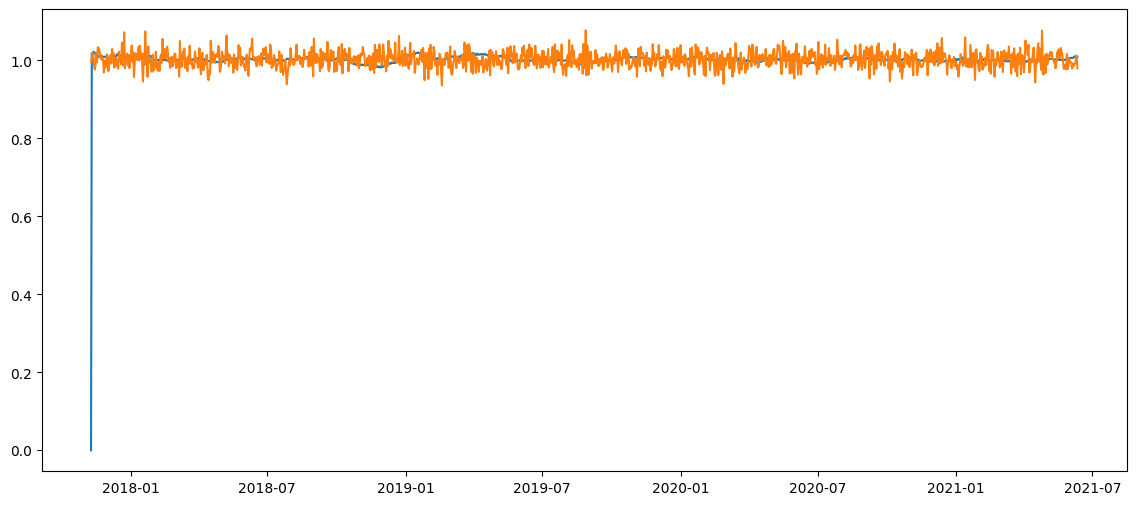

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

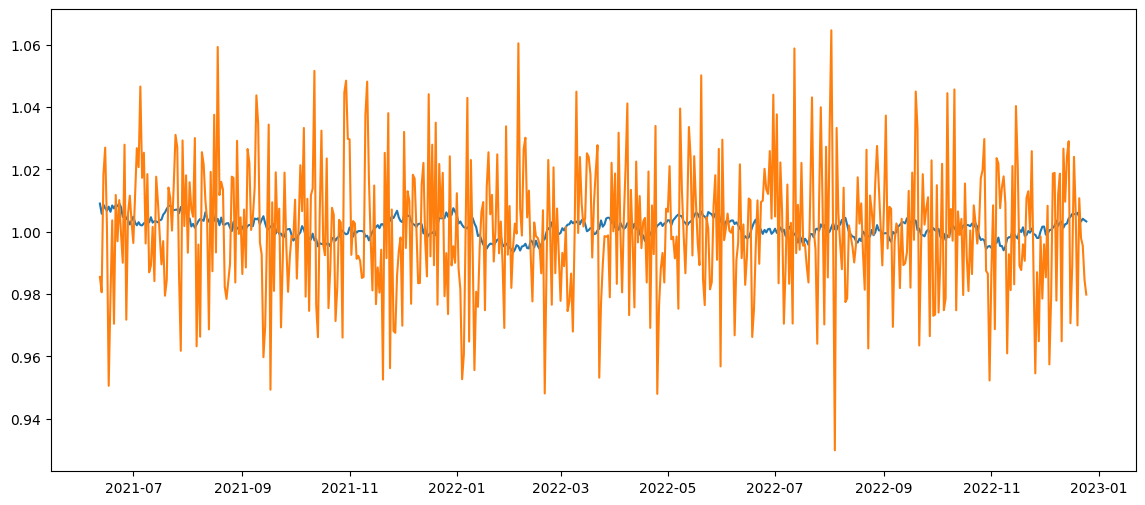

In [42]:
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## **Stacking**

In [43]:
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_USDT']= stacked_

RMSE 0.02079610871759101
MSE 0.00043247813779386483
MAE 0.01655324617118378


# **Plant Sensor Data**

In [90]:
df=pd.read_csv('measures.csv')
df.head()

,mp,temperature,humidity,moisture,light,date,time
0,n1,24.7,57.9,1995,0.0,2022-09-15,00:00:04
1,n1,24.7,58.0,1991,0.0,2022-09-15,00:00:09
2,n1,24.7,58.2,1994,0.0,2022-09-15,00:00:14
3,n1,24.6,58.0,1993,0.0,2022-09-15,00:00:19
4,n1,24.6,58.0,1986,0.0,2022-09-15,00:00:25


In [ ]:
df.date=pd.to_datetime(df['date'] + ' ' + df['time'])
df.index = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')

In [ ]:
plt.figure(figsize=(14, 6))
humidity=df['humidity']
humidity = jitter_series(humidity)
humidity.plot()

In [ ]:
WINDOW_SIZE=5
X, y=data_to_X_y(humidity, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Humidty']= LSTM_

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for Plant Sensor data (Jitter Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=humidity.head(163782).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=humidity.tail(70193).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **ARIMA**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(humidity, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_humidity']= arima

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [ ]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Humidity']= stacked_

# **Results**

In [ ]:
Result=pd.DataFrame(score_dict).T
Result.columns=['RMSE', 'MSE', 'MAE']
Result[ 'Dat']=Result.index.str.split('_')
Result['Data']=Result[ 'Dat'].str[1]
Result['Model']=Result['Dat'].str[0]
Result.drop('Dat', axis=1, inplace=True)
Result=Result.set_index('Data')
Result=Result[['Model', 'RMSE', 'MSE', 'MAE']]
Result.to_csv('/content/drive/MyDrive/New TS DA/Jitter_Augmentation.csv')

In [ ]:
Result